In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
# GIS imports
from shapely.geometry import Polygon, shape, Point, box
from opera_coverage import *
import geopandas as gpd
import pandas as pd
from shapely.geometry import box, Point
from rasterio.crs import CRS

# Misc imports
import numpy as np
from itertools import product
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import concurrent.futures
from typing import List
import matplotlib.pyplot as plt
import contextily as cx

import pickle

In [3]:
output_path = Path('../output_dfs')
output_path.mkdir(exist_ok=True)

In [4]:
# helper functions
import sys
import time

# wrapper function for get_coverage, returns string if thread crashed while running
def get_cadence_df(geo:Polygon, daterange:List[datetime]):
    results = pd.DataFrame(columns=['center_x','center_y','startTime','geometry','sensor','fileID'])
    for i in range(3):
        try:
            df = get_coverage(['sentinel1','sentinel2','landsat8'], geo, daterange)
            df['center_x'] = geo.centroid.x
            df['center_y'] = geo.centroid.y
            return df
        except:
            print("Oops!", str(sys.exc_info()[0]), " occurred.")
            print(sys.exc_info()[1])
            print(sys.exc_info()[2])
            print("Attempt " + str(i) + " failed")
            time.sleep(2)
    return 'Thread crashed'

In [5]:
# main function, takes an area of interest as a polygon and a daterange as a list of two datetimes
# grid resolution can be changed from default values
def get_area_coverage(aoi: Polygon, date: List[datetime], x_res = 1, y_res = 0.25, radius = 0.1):

    df_points = grid_intersect(aoi, x_res, y_res, radius)
    results = lookup(df_points, date)
    
    return results

In [6]:
# creates an array of polygon circles within the rectangular bounds of the aoi, then takes intersection with the aoi, returns dataframe
def grid_intersect(aoi: Polygon, x_res, y_res, radius):
    
    x_start, y_start, x_end, y_end = aoi.bounds
    df = make_grid(x_start, y_start, x_end, y_end, x_res, y_res, radius)
    indices = df.geometry.intersects(aoi)
    
    return df[indices].reset_index(drop=True)

In [7]:
# for each geometry in dataframe, runs search through asf and hls search, reformats to dataframe
def lookup(df_points: gpd.GeoDataFrame, daterange) -> gpd.GeoDataFrame:
    results = []

    for i in range(len(df_points) // 200 + 1):
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            results += list(executor.map(get_cadence_df, tqdm(df_points.geometry[(i * 200):(i + 1) * 200]), [daterange] * 200))
    
    results = pd.concat([i for i in results if type(i) is not str])
        
    return results

In [8]:
# Make grid with specified x and y resolution, returns as geodataframe
def make_grid(x_start, y_start, x_end, y_end, x_res = 1, y_res = 0.25, radius = 0.1):
    lon_lat = list(product(
                np.linspace(x_start + (x_res/2), x_end - (x_res/2), int((x_end - x_start) / x_res)), 
                np.linspace(y_start + (y_res/2), y_end - (y_res/2), int((y_end - y_start) / y_res))
                ))

    geometry = [Point(lon, lat).buffer(radius) for lon, lat in lon_lat]

    center_x = [lon for lon, _ in lon_lat]
    center_y = [lat for _, lat in lon_lat]

    df = gpd.GeoDataFrame({'center_x':center_x, 'center_y':center_y}, geometry = geometry, crs=CRS.from_epsg(4326))
    
    return df

In [13]:
# helper functions

# the below two functions help grid the data into 1 degree by 1 degree boxes
def get_lat(geom):
    return int(np.floor(geom.centroid.coords.xy[1][0]))
def get_lon(geom):
    return int(np.floor(geom.centroid.coords.xy[0][0]))

# creates the 1 degree by 1 degree box
def make_box(row):
    return box(row['lon'], row['lat'], row['lon'] + 1, row['lat'] + 1)

In [14]:
def calculate_averages(results: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    results['lat_lon_str'] = results.apply(lambda row: str(row['center_x']) + '_' + str(row['center_y']), axis=1)
    
    df = pd.DataFrame(columns = ['av_cad_days','avail_sensors','n_avail_sensors'])
    
    df['av_cad_days'] = [results[results.lat_lon_str == i].cadence.mean().total_seconds()/(3600 * 24) for i in results.lat_lon_str.unique()]
    df['avail_sensors'] = [results[results.lat_lon_str == i].sensor.unique() for i in results.lat_lon_str.unique()]
    df['n_avail_sensors'] = [len(results[results.lat_lon_str == i].sensor.unique()) for i in results.lat_lon_str.unique()]
    geometry = [Point(float(i.split('_')[0]), float(i.split('_')[1])) for i in results.lat_lon_str.unique()]
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))
    
    return df

In [15]:
# Re-grid results to 1x1 degree cells
def regrid(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df_temp['lon'] = df_temp.geometry.map(get_lon)
    df_temp['lat'] = df_temp.geometry.map(get_lat)
    
    return df_temp

# Use geodataframe groupby function to aggregate rows to 1 by 1 degree box
def aggregator(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ag = df_temp.copy()
    geom = df_ag.apply(make_box, axis=1)
    df_ag = gpd.GeoDataFrame(df_ag,
                             geometry=geom,
                             crs = CRS.from_epsg(4326))
    return df_ag

In [16]:
# main function, transforms dataframe of search results to plot dataframe
def get_boxes(results: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df = calculate_averages(results)
    df = regrid(df)
    df_ag = aggregator(df)
    
    return df_ag

In [17]:
# filters search results according to sensors
def separate_sensors(results: gpd.GeoDataFrame, sensor: list) -> gpd.GeoDataFrame:
    
    df = results[results.sensor.isin(sensor)].reset_index(drop=True)
    df['cadence'] = df.groupby(['center_x','center_y'])['startTime'].transform(lambda x: x.diff())
    df.reset_index(drop=True,inplace=True)
    
    return df

Specify area of interest as a shapely polygon and the daterange as a list of two datetimes.

In [10]:
test_aoi = Polygon(([-119, 38],[-116,38],[-116, 40],[-119,40],[-119,38]))
daterange = [datetime(2022,1,1),datetime(2022,2,1)]

In [11]:
df = get_area_coverage(test_aoi, daterange, x_res = 1, y_res = 1, radius = 0.1)

100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.35it/s]


In [18]:
df_box = get_boxes(df)

Text(380.7299999999986, 0.5, 'Latitude')

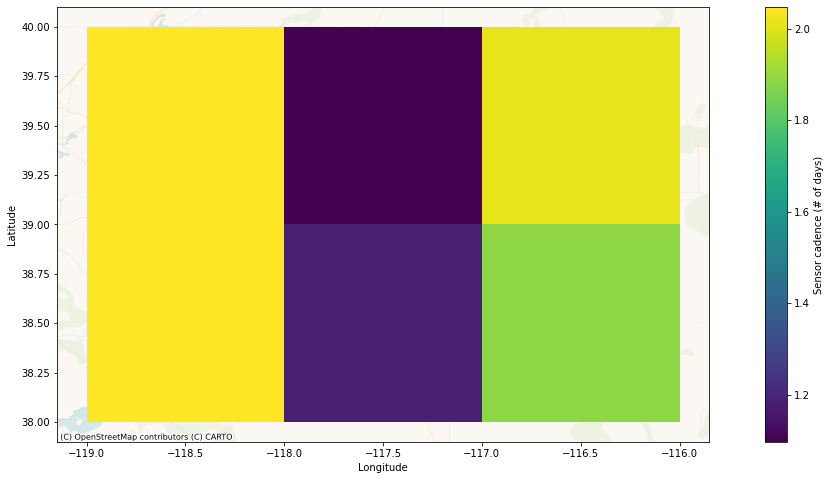

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
df_box.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('')